## 백테스트
### 좁은 의미
- 과거 데이터의 일정 기간에 전략을 적용해 매매를 시뮬레이션 하고 성과를 확인하는 것
### 넓은 의미
1. 전략의 백테스트 코드 작성
2. 과거 데이터 기간 선정과 파라미터 최적화
3. 전략 검증: 파라미터 최적화에 사용하지 않은 그 이후 데이터를 활용한 성능 평가

In [9]:
# 백테스트
## 좁은 의미
## 넓은 의미

## Event-Driven Backtest

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

ticker = 'AAPL'
start_date = '2022-08-01'
end_date = '2024-08-01'
df = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
if isinstance(df.columns, pd.MultiIndex):
    df_flat = df.copy()
    df_flat.columns = df_flat.columns.droplevel(1)
else:
    df_flat = df.copy()

df_flat = df_flat[['Close','High','Low','Open','Volume']]
print(df_flat.head())


Price            Close        High         Low        Open    Volume
Date                                                                
2022-08-01  159.168198  161.218041  158.557192  158.675447  67829400
2022-08-02  157.689972  160.055183  157.315492  157.778678  59907000
2022-08-03  163.721237  164.174559  158.419239  158.507930  82507500
2022-08-04  163.405869  164.765864  162.045873  163.602966  55474100
2022-08-05  163.178894  163.672329  160.859744  161.066994  56697000


### Event-Driven Backtest #1

In [12]:
# 책 원본 코드
short_window = 10
long_window = 20
data = df_flat.copy()

data['Short_MA'] = data['Close'].ewm(span=short_window, adjust=False).mean() #adjust: 정규화 관련
data['Long_MA'] = data['Close'].ewm(span=long_window, adjust=False).mean()

data = data[long_window:].copy()

cash_init = 10000 # 초기 현금
cash = cash_init
asset = [cash] # 보유 자산 가치 기록 리스트
pos = 0 # 포지션 (1: 매수 - > 주식 보유, 0: 현금 보유)

for i in range(1, len(data)):
    if pos == 0:
        if data['Short_MA'].iloc[i] > data['Long_MA'].iloc[i] and data['Short_MA'].iloc[i-1] < data['Long_MA'].iloc[i-1]:# 골든 크로스
            pos = 1
            entry_price = data['Close'].iloc[i]
            num = int(cash / entry_price)
            cash -= num * entry_price
    elif pos == 1:
        if data['Short_MA'].iloc[i] < data['Long_MA'].iloc[i] and data['Short_MA'].iloc[i-1] > data['Long_MA'].iloc[i-1]:# 데드 크로스
            pos = 0
            cash += data['Close'].iloc[i] * num
    if pos == 0:
        asset.append(cash)
    elif pos == 1:
        asset.append(cash + data['Close'].iloc[i] * num)

# 누적 수익률 계산, 출력
data['Cumulative_Return'] = np.array(asset) / cash_init
final_cum_return = data['Cumulative_Return'].iloc[-1] - 1
print(f'Final cumulative return of the strategy: {100*final_cum_return:.2f}%')

Final cumulative return of the strategy: 29.98%


### Event-Driven Backtest #2

In [13]:
short_window = 10
long_window = 20
data = df_flat.copy()

# 지수가중 이동평균선 계산
data['Short_MA'] = data['Close'].ewm(span=short_window, adjust=False).mean() #adjust: 정규화 관련
data['Long_MA'] = data['Close'].ewm(span=long_window, adjust=False).mean()
data = data[long_window:].copy()

# 포지션과 시그널 계산
data['Position'] = np.where(data['Short_MA'] > data['Long_MA'], 1, 0)
data['Signal'] = data['Position'].diff().fillna(0) # 1: 매수, -1: 매도

cash_init = 10000 # 초기 현금
cash = cash_init
asset = np.zeros(len(data))
asset[0] = cash
pos = 0 # 포지션(1: 매수 -> 주식 보유, 0: 현금 보유)
num = 0

prices = data['Close'].values
signals = data['Signal'].values

for i in range(1, len(data)):
    if pos == 0:
        if signals[i] == 1: # 골든 크로스
            pos = 1
            entry_price = prices[i]
            num = int(cash / entry_price)
            cash -= entry_price * num
    elif pos == 1:
        if signals[i] == -1: # 데드 크로스
            pos = 0 # 포지션 갱신
            cash += prices[i] * num # 주식 매도에 따른 현금 갱신
    
    # 자산가치 갱신, 기록
    if pos == 0:
        asset[i] = cash
    elif pos == 1:
        asset[i] = cash + prices[i] * num

# 시각화를 위한 매수, 매도 시점의 가격 칼럼 계산
data['Buy_Price'] = np.where(data['Signal'] == 1, data['Close'], np.nan)
data['Sell_Price'] = np.where(data['Signal'] == -1, data['Close'], np.nan)

# 누적 수익률 계산, 출력
data['Cumulative_Return'] = np.array(asset) / cash_init
final_cum_return = data['Cumulative_Return'].iloc[-1] - 1
print(f'Final cumulative return of the strategy: {100*final_cum_return:.2f}%')

Final cumulative return of the strategy: 29.98%


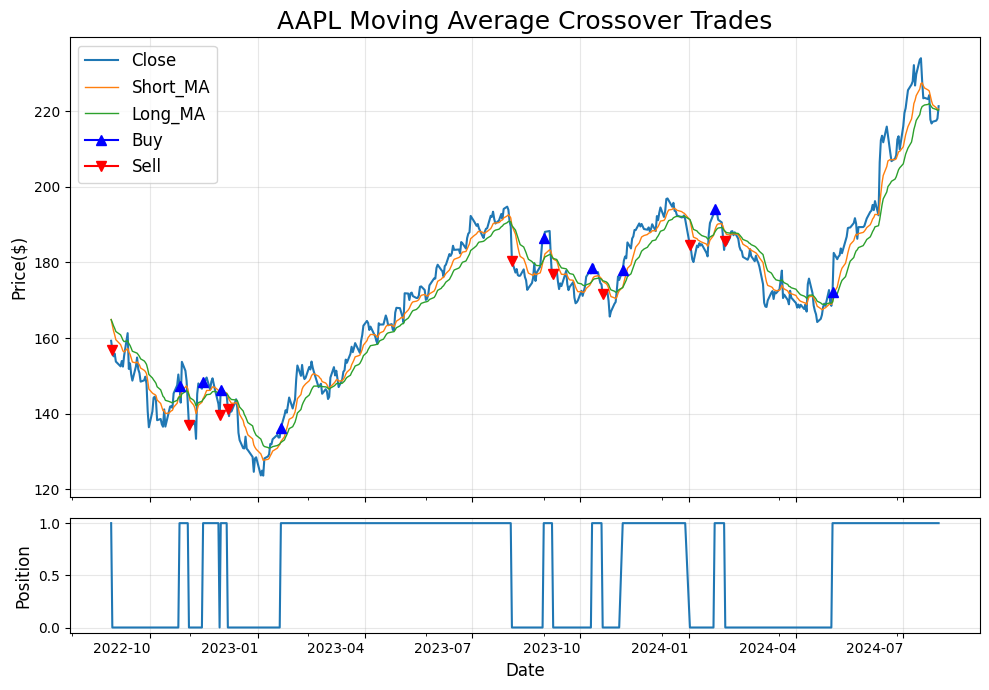

In [14]:
fig, ax = plt.subplots(2, 1, sharex=True, height_ratios=(8,2), figsize=(10, 7))

data['Close'].plot(ax=ax[0], label='Close')
data['Short_MA'].plot(ax=ax[0], label='Short_MA', linewidth=1)
data['Long_MA'].plot(ax=ax[0], label='Long_MA', linewidth=1)
data['Buy_Price'].plot(ax=ax[0], label='Buy', marker='^', color='b', markersize=7)
data['Sell_Price'].plot(ax=ax[0], label='Sell', marker='v', color='r', markersize=7)

ax[0].set_title(f'{ticker} Moving Average Crossover Trades', fontsize=18)
ax[0].set_ylabel('Price($)', fontsize=12)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.3)

data['Position'].plot(ax=ax[1])
ax[1].set_xlabel('Date', fontsize=12)
ax[1].set_ylabel('Position', fontsize=12)
ax[1].grid(alpha=0.3)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 이동평균선 교차 전략 Vectorized Backtest

In [ ]:
short_window = 10
long_window = 20
data = df_flat.copy()
data['Short_MA'] = data['Close'].ewm(span=short_window, adjust=False).mean()
data['Long_MA'] = data['Close'].ewm(span=long_window, adjust=False).mean()
data = data[long_window:].copy()

# 포지션 및 시그널 계산
positions = pd.Series(np.where(data['Short_MA'] > data['Long_MA'], 1, 0), index=data.index)
signals = positions.diff().fillna(0) # 1: 매수, -1: 매도

data['Position'] = np.nan # 포지션 초기화
data.loc[signals == 1, 'Position'] = 1 # 매수 시점 포지션 1로 설정
data.loc[signals == -1, 'Position'] = 0 # 매도 시점 포지션 0으로 설정
data['Position'] = data['Position'].ffill()
data['Position'] = data['Position'].replace(np.nan, 0)

data['Signal'] = data['Position'].diff().fillna(0) # 최종 시그널 계산

# 매수, 매도 시점의 가격 기록
data['Buy_Price'] = np.where(data['Signal'] == 1, data['Close'], np.nan)
data['Sell_Price'] = np.where(data['Signal'] == -1, data['Close'], np.nan)

# 일별 수익률 및 누적 수익률 계산
data['Daily_Return'] = np.where(data['Position'].shift() == 1, data['Close'].pct_change(), 0)
data['Cumulative_Return'] = (1 + data['Daily_Return']).cumprod()

# 최종 누적 수익률 출력력
final_cum_return = data['Cumulative_Return'].iloc[-1] - 1
print(f'Final cumulative return of the strategy: {100*final_cum_return:.2f}%')


## 파라미터 최적화

In [5]:
# Vectorized Backtest 함수수
def mac_strategy(df, sw, lw):
    short_window = sw
    long_window = lw
    data = df.copy()
    data['Short_MA'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['Long_MA'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data = data[long_window:].copy()

    positions = pd.Series(np.where(data['Short_MA'] > data['Long_MA'], 1, 0), index=data.index)
    signals = positions.diff().fillna(0) # 1: 매수, -1: 매도

    data['Position'] = np.nan # 포지션 초기화
    data.loc[signals == 1, 'Position'] = 1 # 매수 시점 포지션 1로 설정
    data.loc[signals == -1, 'Position'] = 0 # 매도 시점 포지션 0으로 설정
    data['Position'] = data['Position'].ffill()
    data['Position'] = data['Position'].replace(np.nan, 0)

    data['Signal'] = data['Position'].diff().fillna(0) # 최종 시그널 계산

    data['Buy_Price'] = np.where(data['Signal'] == 1, data['Close'], np.nan)
    data['Sell_Price'] = np.where(data['Signal'] == -1, data['Close'], np.nan)

    data['Daily_Return'] = np.where(data['Position'].shift() == 1, data['Close'].pct_change(), 0)
    data['Cumulative_Return'] = (1 + data['Daily_Return']).cumprod()

    final_cum_return = data['Cumulative_Return'].iloc[-1] - 1
    print(f'Final cumulative return of the strategy: {100*final_cum_return:.2f}%')

    return data, final_cum_return

In [26]:
# parameter oprimization
def parameter_optimizer1(input_df):
    short_window = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
    long_window = [22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
    # short_window = [n for n in range(2, 22)]
    # long_window = [n for n in range(10, 51)]
    ref_list = [] # 각 파라미터 조합과 수익률을 저장할 리스트

    # 단기, 장기 모든 조합에 대해 테스트
    for x1, x2 in [(a, b) for a in short_window for b in long_window]:
        df = input_df.copy()
        _, ret = mac_strategy(df, x1, x2)
        ref_list.append((x1, x2, ret))

    # 수익률이 최대인 파라미터 조합을 찾아 출력하고 결과를 반환
    optimal_params = max(ref_list, key=lambda x: x[2])
    optimal_df = pd.DataFrame(ref_list, columns=['short_window', 'long_window', 'ror'])
    print(f'Optimal parameters: {optimal_params[0], optimal_params[1]}, \n,
          Optimized Return: {100*optimal_params[2]:.2f}%')
    
    return optimal_params, optimal_df  


In [ ]:
o_params, o_df = parameter_optimizer1(df_flat)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# x, y, z 추출
x = o_df['short_window'].values
y = o_df['long_window'].values
z = o_df['ror'].values

# 보간용 그리드 생성
xi = np.unique(x)
yi = np.unique(y)
Xi, Yi = np.meshgrid(xi, yi)
Zi = o_df.pivot(index='long_window', columns='short_window', values='ror').values

# 3D 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 서피스 플롯 (외곽선 없음)
surf = ax.plot_surface(Xi, Yi, Zi, cmap='viridis', edgecolor='none', alpha=0.9)

# 🔴 RoR > 0.5 인 지점만 추출해서 점으로 표시
mask = o_df['ror'] > 0.5
x_high = o_df['short_window'][mask]
y_high = o_df['long_window'][mask]
z_high = o_df['ror'][mask]

ax.scatter(x_high, y_high, z_high, color='red', s=50, label='RoR > 50%', depthshade=True)

# 축 라벨 및 제목
ax.set_xlabel('Short Window')
ax.set_ylabel('Long Window')
ax.set_zlabel('Return (RoR)')
ax.set_title('RoR Surface with High-RoR Points')

# 컬러바 & 범례
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.legend()

plt.show()


In [3]:
def parameter_optimizer1b(input_df):
    short_window = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
    long_window = [22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]
    ref_list = [] # 각 파라미터 조합과 수익률을 저장할 리스트

    # 단기, 장기 모든 조합에 대해 테스트
    for x1, x2 in [(a, b) for a in short_window for b in long_window]:
        df = input_df.copy()
        _, ret = mac_strategy(df, x1, x2)
        ref_list.append((x1, x2, ret))

    # 여러 개의 최적해를 모두 찾고 최적값은 중위값을 선택
    max_ror = max(ref_list, key=lambda x: x[2])[2]
    max_tups = [tup for tup in ref_list if tup[2] == max_ror]
    params1 = [tup[0] for tup in max_tups]
    params2 = [tup[1] for tup in max_tups]
    opt_param1 = int(np.median(params1))
    opt_param2 = int(np.median(params2))

    optimal_df = pd.DataFrame(ref_list, columns=['short_window', 'long_window', 'ror'])
    print(f'Max Tuples:{max_tups}')
    print(f'Optimal Parameters: {opt_param1}, {opt_param2}, '
          f'Optimized Return: {100*max_ror:.2f}%')
    
    return (opt_param1, opt_param2), optimal_df

In [6]:
o_params, o_df = parameter_optimizer1b(df_flat)

Final cumulative return of the strategy: 21.14%
Final cumulative return of the strategy: 21.14%
Final cumulative return of the strategy: 22.45%
Final cumulative return of the strategy: 22.60%
Final cumulative return of the strategy: 28.55%
Final cumulative return of the strategy: 30.96%
Final cumulative return of the strategy: 28.63%
Final cumulative return of the strategy: 15.96%
Final cumulative return of the strategy: 13.64%
Final cumulative return of the strategy: 13.64%
Final cumulative return of the strategy: 15.68%
Final cumulative return of the strategy: 18.25%
Final cumulative return of the strategy: 15.34%
Final cumulative return of the strategy: 16.23%
Final cumulative return of the strategy: 17.17%
Final cumulative return of the strategy: 22.36%
Final cumulative return of the strategy: 22.36%
Final cumulative return of the strategy: 22.36%
Final cumulative return of the strategy: 26.05%
Final cumulative return of the strategy: 26.05%
Final cumulative return of the strategy:

## 전략의 성과 지표

### 연평균 성장률 GACR
$$
GACR = \left( \frac{V_f}{V_0} \right)^{\frac{1}{T}} - 1
$$


### 샤프 지수
$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$


In [ ]:
def teat_sheet1(data):

    # 투자 기간
    trading_period = len(data) / 252
    print(f'Trading Period: {trading_period:.1f} years')

    # 수익률 계산
    buy_and_hold = data['Close'].iloc[-1] / data['Close'].iloc[0] - 1
    final_cum_return = data['Cumulative_Return'].iloc[-1] - 1
    print(f'Finale cumulative return of the strategy: '
          f'{100*final_cum_return:.2f}%, Buy&Hold: {100*buy_and_hold:.2f}%')
    
    # 연평균 성장률 GACR
    CAGR_strategy = (data['Cumulative_Return'].iloc[-1]) ** (1/trading_period) - 1
    CAGR_benchmark = (1 + buy_and_hold) ** (1/trading_period) - 1
    print(f'CAGR of the strategy: {100*CAGR_strategy:.2f}%, '
          f'CAGR of the benchmark: {100*CAGR_benchmark:.2f}%')
    
    # 샤프 지수
    risk_free_rate = 0.03
    strategy_daily_return = data['Cumulative_Return'].iloc
    
